$$
\begin{cases}
	\dot{x}_i=v\cos \theta _i\\
	\dot{y}_i=v\sin \theta _i\\
	\dot{\theta}_i=\omega _i+K_1\sum_{j=1}^N{A_{ij}\sin \left( \theta _j-\theta _i \right) +K_2\sum_{j=1}^N{\sum_{k=1}^N{G_{ijk}\sin \left( \theta _j+\theta _k-2\theta _i \right)}}}\\
\end{cases}
\\
A_{ij}=H\left( d_1-d_{ij}\left( t \right) \right) =\begin{cases}
	1,&		d_{ij}\left( t \right) \le d_1\\
	0,&		\mathrm{else}\\
\end{cases}
\\
\begin{aligned}
	\,\,G_{ijk}&=H\left( d_2-d_{ij}\left( t \right) \right) H\left( d_2-d_{jk}\left( t \right) \right) H\left( d_2-d_{ik}\left( t \right) \right)\\
	&=\begin{cases}
	1,&		\left( d_{ij}\left( t \right) \le d_2 \right) \land \left( d_{jk}\left( t \right) \le d_2 \right) \land \left( d_{ik}\left( t \right) \le d_2 \right)\\
	0,&		\mathrm{else}\\
\end{cases}\\
\end{aligned}
\\
d_{ij}=\sqrt{\left[ x_i\left( t \right) -x_j\left( t \right) \right] ^2+\left[ y_i\left( t \right) -y_j\left( t \right) \right] ^2}
\\

$$


In [2]:
from main import *

In [6]:
(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) < 6) * np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

array([1, 2, 3, 4, 5, 0, 0, 0, 0, 0])

In [2]:
model = ThreeBody(strengthLambda1=0.06, frustration=np.pi*1/12, strengthLambda2=0.06, 
                  distanceD1=0.9, distanceD2=0.9, agentsNum=500, boundaryLength=5,
                  tqdm=True, savePath="./data", overWrite=True)
# model.tempForK = model.tempForK

In [8]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [16]:
model.run(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
%%timeit
model.pointTheta

2.82 s ± 157 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
self = model
phaseTheta = self.phaseTheta[:, np.newaxis, np.newaxis]
other1 = self.phaseTheta[np.newaxis, np.newaxis, :]
other2 = self.phaseTheta[np.newaxis, :, np.newaxis]
omegaTheta = self.omegaTheta
strengthLambda1 = self.strengthLambda1
strengthLambda2 = self.strengthLambda2
K1 = self.K1
K2 = self.K2
dt = self.dt
frustration = self.frustration

In [5]:
%%timeit
np.sum(K1 * np.sin(other1 - phaseTheta + frustration), axis=(1, 2))

4.55 ms ± 279 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%%timeit
np.sum(K2 * np.sin(other1 + other2 - 2 * phaseTheta + 2 * frustration), axis=(1, 2))

2.24 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
model.omegaTheta.sum()

4.790024640710044

In [4]:
model.run(50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
import pandas as pd

def draw_mp4(model):

    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    shift = 0
    class1, class2 = (
        np.concatenate([np.ones(model.agentsNum // 2), np.zeros(model.agentsNum // 2)]).astype(bool), 
        np.concatenate([np.zeros(model.agentsNum // 2), np.ones(model.agentsNum // 2)]).astype(bool)
    )

    def plot_frame(i):
        pbar.update(1)
        positionX = totalPositionX[i]
        phaseTheta = totalPhaseTheta[i]
        fig.clear()
        ax1 = plt.subplot(1, 2, 1)
        ax1.quiver(
            positionX[class1, 0], positionX[class1, 1],
            np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato'
        )
        ax1.quiver(
            positionX[class2, 0], positionX[class2, 1],
            np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
        )
        limShift = 0
        ax1.set_xlim(0 - limShift, model.boundaryLength + limShift)
        ax1.set_ylim(0 - limShift, model.boundaryLength + limShift)

        ax2 = plt.subplot(1, 2, 2, projection='3d')
        hist, bins = np.histogram(phaseTheta[class1], bins=100, range=(-np.pi, np.pi))
        # print(np.array([np.zeros_like(hist), hist]).shape)
        ax2.plot_surface(
            np.cos(bins[:-1]), np.sin(bins[:-1]), 
            np.array([np.zeros_like(hist), hist]), 
            color='tomato', alpha=0.5, edgecolor="tomato"
        )
        hist, bins = np.histogram(phaseTheta[class2], bins=100, range=(-np.pi, np.pi))
        ax2.plot_surface(
            np.cos(bins[:-1]) + shift, np.sin(bins[:-1]) + shift,
            np.array([np.zeros_like(hist), hist]), 
            color='dodgerblue', alpha=0.5, edgecolor="dodgerblue"
        )
        ax2.set_xlabel(r"$\cos(\theta_I)$")
        ax2.set_ylabel(r"$\sin(\theta_I)$")
        ax2.set_zlabel("Count")
        ax2.set_zlim(0, 1000)

    pbar = tqdm(total=TNum)
    fig, ax = plt.subplots(figsize=(11, 5))
    ani = ma.FuncAnimation(fig, plot_frame, frames=np.arange(0, TNum, 1), interval=50, repeat=False)
    ani.save(f"./mp4/{model}.mp4", dpi=200, writer="ffmpeg")

    plt.close()

    pbar.close()

In [6]:
draw_mp4(model)

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
targetPath = f"./data/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)

positionX = totalPositionX[-1, :, :]#坐标：时间(-1是最后一时刻),振子，0横坐标:1纵坐标
phaseTheta = totalPhaseTheta[-1, :]#相位
pointTheta = totalPointTheta[-1, :]#相速度

In [8]:
totalPositionX[-1,:,:]#坐标

array([[3.84990746, 0.04415883],
       [3.16187314, 3.80363505],
       [2.5195789 , 1.17751835],
       [1.00726312, 3.86020544],
       [0.80920682, 0.48943631],
       [3.48588591, 4.77720498],
       [0.07579958, 2.53957471],
       [4.11902749, 3.08428724],
       [3.64450829, 1.50756178],
       [4.56957649, 3.62945558],
       [2.66595293, 0.74843573],
       [1.89122537, 3.31599064],
       [2.16690278, 2.12765911],
       [3.08584524, 2.62555834],
       [3.31115873, 3.01512238],
       [4.01472503, 2.66712197],
       [4.59838645, 1.57263237],
       [0.41360712, 1.54844503],
       [0.62843388, 4.15666682],
       [0.23232368, 3.07151943],
       [2.67998901, 4.08429891],
       [0.94563153, 4.24983454],
       [1.73046714, 3.72006634],
       [1.53606405, 4.39888369],
       [1.61115281, 0.88245371],
       [1.91011233, 0.49604617],
       [4.15602188, 0.78775131],
       [1.9364397 , 4.66344228],
       [4.9729345 , 2.33039453],
       [4.17126259, 1.30093537],
       [3.

In [9]:
pd.DataFrame(totalPositionX[-1, :, :]).to_excel("totalPositionX.xlsx")

In [10]:
totalPhaseTheta[-1,:]#相位

array([-1.79384837,  1.68502898,  1.14546506,  1.24569665,  2.2238834 ,
        0.28007236, -0.33554595,  0.55692582,  0.91440025,  2.0050059 ,
        2.45958546, -1.09108061, -2.51386894,  1.72342435,  0.18967244,
        1.73557209, -0.29134862,  2.938627  ,  0.19881036, -1.69994946,
        3.09767755, -2.52445347, -2.04280877, -0.27360196,  1.41390544,
        2.73562727,  0.83703292, -1.29395529,  0.95949921,  0.727849  ,
        0.04090818,  2.77326148,  2.14156556, -2.92914361,  0.48959792,
        2.91798996,  1.29202898, -2.7232931 , -1.17337918,  2.16928371,
       -0.26597314, -1.75154392, -2.27183972,  2.09534343,  1.19750366,
        0.35611793, -1.22786112,  0.92863051, -0.71858975,  0.49301833,
        1.16189768,  2.21307882, -2.42962155,  0.11124277,  0.99239876,
       -2.07708979,  3.00792664, -3.0058155 ,  1.89902872, -1.50628777,
       -1.26592088, -3.05631549, -0.17093708,  2.88208533,  2.56302615,
       -1.71133988, -0.57465141,  2.94623217, -1.35538062,  2.84

In [11]:
pd.DataFrame(totalPhaseTheta[-1,  :]).to_excel("totalPhaseTheta.xlsx")

In [12]:
totalPointTheta[-1,:]#湘速度

array([-8.28018703e-02,  4.66429363e-02,  1.54465072e-02, -2.66814671e-02,
       -2.88911382e-04,  7.54717772e-02,  3.37911893e-02,  1.55677073e-01,
        4.03552734e-03,  1.91346314e-02, -4.98188604e-03,  7.91122465e-03,
       -9.45014086e-02,  5.86569965e-02,  2.58204494e-02,  8.84379526e-04,
        7.55654017e-02,  5.04578628e-01, -1.22048504e-02, -5.44894596e-02,
       -8.68094525e-02, -2.77437420e-02,  1.50945816e-02,  5.29865381e-02,
       -3.31039835e-01,  3.23906238e-02,  1.85648602e-01,  1.16496926e-04,
        9.35970768e-03, -5.69786380e-02,  6.41869988e-02, -1.16538009e-01,
        1.47117214e-01,  3.04878547e-01, -1.10180189e-01, -5.97901185e-02,
        5.01217256e-02,  1.76131252e-01,  8.45871439e-02,  2.08092840e-03,
        3.54054843e-02,  1.30101358e-01,  5.72647294e-02,  1.17137322e-01,
        9.73596109e-02,  2.20869431e-01,  5.97497129e-02,  1.78041276e-03,
        4.12788285e-02,  9.82699860e-02, -3.29703936e-01,  6.06233450e-02,
        2.70720974e-02,  

In [13]:
pd.DataFrame(totalPointTheta[-1,  :]).to_excel("totalPointTheta.xlsx")

In [14]:
totalPositionX.shape#(TNum,agentsNum,2)

(3, 200, 2)

(0.0, 5.0)

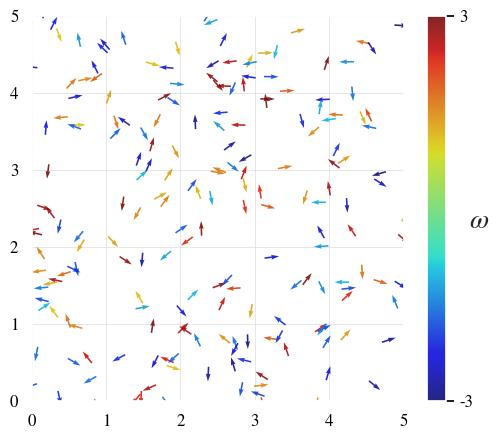

In [15]:
unitOmega = (model.omegaTheta + 3) / 6
ax = plt.subplot(1, 1, 1)
line = ax.quiver(
    positionX[:, 0],  # 振子横坐标 
    positionX[:, 1],  # 振子纵坐标
    np.cos(phaseTheta),  # 速度的横向分量 
    np.sin(phaseTheta),   # 速度的纵向分量
    color=new_cmap(unitOmega),  # 根据自然频率wi颜色
    cmap=new_cmap,  # 使用自定义的颜色映射
)
cbar = plt.colorbar(line, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['-3', '3'])
cbar.set_label(r"$\omega$", fontsize=20, rotation=0)
ax.set_xlim(0,5)
ax.set_ylim(0,5)

C:\Users\蔡婉柔\AppData\Local\Temp\ipykernel_8100\3411251634.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(modCenters[:, 0], modCenters[:, 1], c=new_cmap(unitOmega), cmap=new_cmap, s=1)
C:\Users\蔡婉柔\AppData\Local\Temp\ipykernel_8100\3411251634.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(np.abs(model.omegaTheta), radii, c=new_cmap(unitOmega), cmap=new_cmap, s=1)


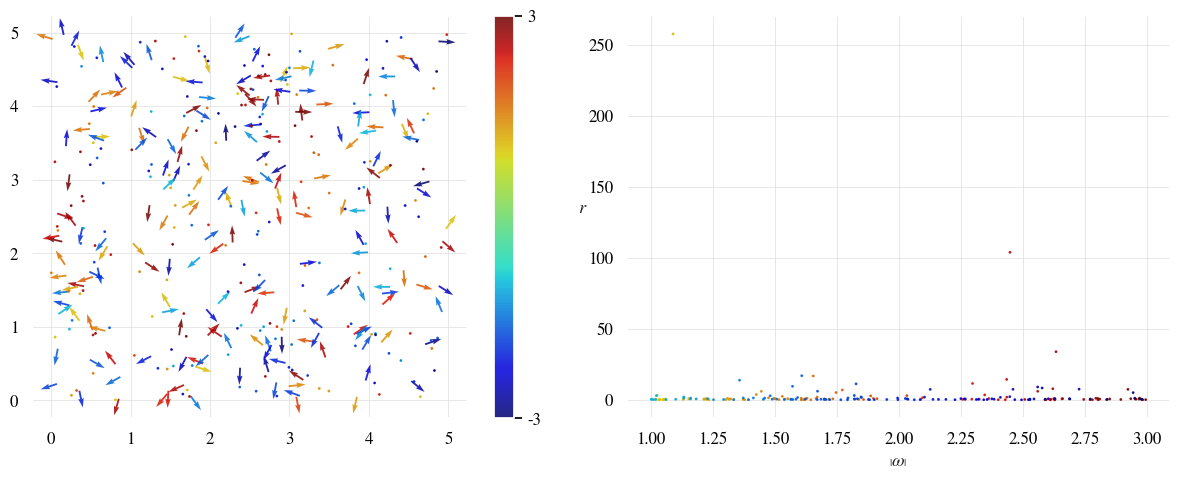

In [16]:
centers = np.array([
    positionX[:, 0] - model.speedV / pointTheta * np.sin(phaseTheta),
    positionX[:, 1] + model.speedV / pointTheta * np.cos(phaseTheta)
]).T
modCenters = np.mod(centers, model.boundaryLength)
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
line = ax.quiver(
    positionX[:, 0],  # 振子横坐标 
    positionX[:, 1],  # 振子纵坐标
    np.cos(phaseTheta),  # 速度的横向分量 
    np.sin(phaseTheta),   # 速度的纵向分量
    color=new_cmap(unitOmega),  # 根据自然频率wi颜色
    cmap=new_cmap,  # 使用自定义的颜色映射
)

cbar = plt.colorbar(line, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['-3', '3'])
# cbar.set_label(r"$\omega$", fontsize=20, rotation=0)

ax.scatter(modCenters[:, 0], modCenters[:, 1], c=new_cmap(unitOmega), cmap=new_cmap, s=1)

ax = plt.subplot(1, 2, 2)
radii = np.sqrt(np.sum((positionX - centers) ** 2, axis=1))
ax.scatter(np.abs(model.omegaTheta), radii, c=new_cmap(unitOmega), cmap=new_cmap, s=1)
ax.set_xlabel(r"$\left| \omega \right|$")
ax.set_ylabel(r"$r$", rotation=0)
# ax.set_ylim(0, 6)

plt.tight_layout()

In [17]:
centers#旋转中心

array([[ 3.49657238e+00,  1.24304516e-01],
       [ 2.52288086e+00,  3.73032210e+00],
       [ 7.50437012e-01,  1.97890836e+00],
       [ 2.07274302e+00,  3.50107611e+00],
       [ 8.32786215e+01,  6.35857135e+01],
       [ 3.37600702e+00,  5.15921616e+00],
       [ 3.68140331e-01,  3.37786780e+00],
       [ 4.01716681e+00,  3.24787281e+00],
       [-2.24466049e+00,  6.04426112e+00],
       [ 3.14722949e+00,  2.96987645e+00],
       [ 6.46181954e+00,  5.42322578e+00],
       [ 5.25527910e+00,  5.06613814e+00],
       [ 1.98045987e+00,  2.38459702e+00],
       [ 2.58034292e+00,  2.54779978e+00],
       [ 3.09210303e+00,  4.15615524e+00],
       [-2.94478937e+01, -2.89715673e+00],
       [ 4.71242446e+00,  1.95290853e+00],
       [ 4.01622370e-01,  1.49020992e+00],
       [ 1.11390465e+00,  1.74704556e+00],
       [-3.13656038e-01,  3.14242913e+00],
       [ 2.69516051e+00,  4.42955021e+00],
       [ 3.19864000e-01,  5.13169542e+00],
       [ 3.50061574e+00,  2.81640513e+00],
       [ 1.

In [18]:
pd.DataFrame(centers[-1,  :]).to_excel("centers.xlsx")

In [19]:
radii#旋转半径

array([3.62310657e-01, 6.43184208e-01, 1.94218664e+00, 1.12437595e+00,
       1.03838069e+02, 3.97499583e-01, 8.87805390e-01, 1.92706604e-01,
       7.43397268e+00, 1.56783788e+00, 6.02181579e+00, 3.79208041e+00,
       3.17455586e-01, 5.11447940e-01, 1.16186979e+00, 3.39220879e+01,
       3.97007087e-01, 5.94555503e-02, 2.45803915e+00, 5.50565195e-01,
       3.45584486e-01, 1.08132493e+00, 1.98746814e+00, 5.66181544e-01,
       9.06235347e-02, 9.26193956e-01, 1.61595615e-01, 2.57517524e+02,
       3.20522831e+00, 5.26513112e-01, 4.67384370e-01, 2.57426741e-01,
       2.03919033e-01, 9.83998392e-02, 2.72281255e-01, 5.01755152e-01,
       5.98542841e-01, 1.70327524e-01, 3.54663825e-01, 1.44166421e+01,
       8.47326355e-01, 2.30589446e-01, 5.23882682e-01, 2.56109663e-01,
       3.08135989e-01, 1.35826854e-01, 5.02094463e-01, 1.68500253e+01,
       7.26764810e-01, 3.05281411e-01, 9.09907244e-02, 4.94858870e-01,
       1.10815204e+00, 7.76680421e-01, 3.61090800e-01, 8.35723994e-01,
      

In [20]:
pd.DataFrame(centers[-1,  :]).to_excel("centers.xlsx")